# Run each scheme

Using this Notebook to test the module, so using IPy extension `autoreload`. 

Test the following:
* running 
* plot methods for model class
* output xr
* plots for model class
* plots for output xr

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [2]:
#%matplotlib notebook  # doesn't work in lab
%matplotlib inline

In [3]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
import crt1d as crt

In [4]:
#schemes_to_test = ['bl', 'bf', 'gd', '2s', 'zq']#, '4s']
#schemes_to_test = ['2s']
schemes_to_test = ['bl']

ms = []
for scheme_ID in schemes_to_test:
    m = crt.model(scheme_ID, nlayers=30)
    #m.plot_canopy()
    m.run()
    ms.append(m)
    
dsets = [m.to_xr() for m in ms]

../crt1d/crt1d.py:222: UserWarning: wl for optical props and toc BC appear to be incompatible
  warnings.warn('wl for optical props and toc BC appear to be incompatible')


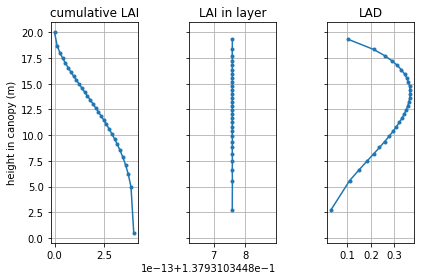

In [5]:
ms[0].plot_canopy()

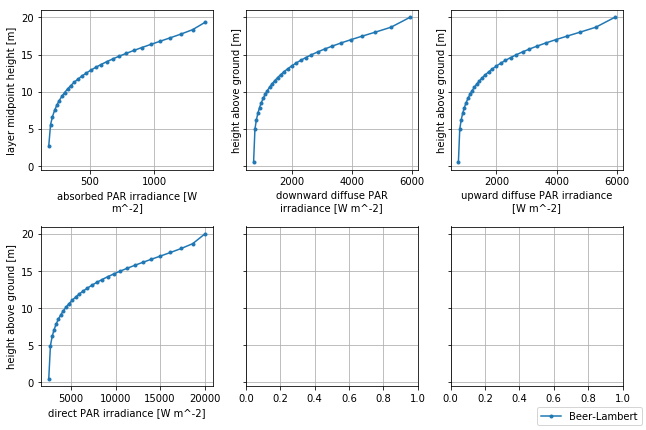

In [6]:
crt.crt1d.plot_PAR(dsets)

In [7]:
m.cd['dlai']

array([0.13793103, 0.13793103, 0.13793103, 0.13793103, 0.13793103,
       0.13793103, 0.13793103, 0.13793103, 0.13793103, 0.13793103,
       0.13793103, 0.13793103, 0.13793103, 0.13793103, 0.13793103,
       0.13793103, 0.13793103, 0.13793103, 0.13793103, 0.13793103,
       0.13793103, 0.13793103, 0.13793103, 0.13793103, 0.13793103,
       0.13793103, 0.13793103, 0.13793103, 0.13793103])

In [8]:
dsets[0]

<xarray.Dataset>
Dimensions:         (wl: 108, z: 30, zm: 29)
Coordinates:
  * z               (z) float64 0.5 4.949 6.202 7.114 ... 17.48 18.02 18.67 20.0
  * wl              (wl) float64 0.3 0.305 0.31 0.315 0.32 ... 2.36 2.45 2.5 2.6
  * zm              (zm) float64 2.724 5.576 6.658 7.488 ... 17.75 18.34 19.33
Data variables:
    I_dr            (z, wl) float64 0.1284 1.222 3.518 ... 15.29 5.482 2.801e-06
    I_df_d          (z, wl) float64 0.1408 1.21 3.163 ... 0.2374 1.198e-07
    I_df_u          (z, wl) float64 0.1408 1.21 3.163 ... 0.2374 1.198e-07
    F               (z, wl) float64 0.4182 3.721 10.07 ... 17.57 6.309 3.22e-06
    dwl             (wl) float64 0.005 0.005 0.005 0.005 ... 0.09 0.05 0.1 0.1
    lai             (z) float64 4.0 3.862 3.724 3.586 ... 0.2759 0.1379 0.0
    dlai            (zm) float64 0.1379 0.1379 0.1379 ... 0.1379 0.1379 0.1379
    aI              (zm, wl) float64 0.009562 0.09101 0.262 ... 0.38 1.941e-07
    aI_df           (zm, wl) float64 0.00203

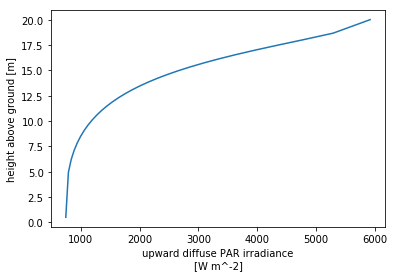

In [9]:
dsets[0]['I_df_u_PAR'].plot(y='z')

In [10]:
dsets[0]['aI_PAR'].dims[0]

'zm'